In [1]:
#import sys
#!conda install --yes --prefix {sys.prefix} plotly
!conda install --yes wrapt
import wrapt

import pandas as pd
from plotly import express as px
import numpy as np
import pandas as pd
import plotly.io as pio
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import re
import time
import datetime

Solving environment: done

# All requested packages already installed.

Retrieving notices: ...working... done



Bad key "text.kerning_factor" on line 4 in
/Users/gaowenhuang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
/Users/gaowenhuang/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
flight2018=pd.read_csv("2018.csv")
flight2018.head()

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 27
0,2018-01-01,UA,2429,EWR,DEN,1517,1512.0,-5.0,15.0,1527.0,...,268.0,250.0,225.0,1605.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01,UA,2427,LAS,SFO,1115,1107.0,-8.0,11.0,1118.0,...,99.0,83.0,65.0,414.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01,UA,2426,SNA,DEN,1335,1330.0,-5.0,15.0,1345.0,...,134.0,126.0,106.0,846.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01,UA,2425,RSW,ORD,1546,1552.0,6.0,19.0,1611.0,...,190.0,182.0,157.0,1120.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01,UA,2424,ORD,ALB,630,650.0,20.0,13.0,703.0,...,112.0,106.0,83.0,723.0,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
airport2017 = pd.read_csv('airport.csv')
airport2017=airport2017.iloc[0:-1:,2:4]
airport2017.columns=list(['Code','Passengers'])
airport2017.head()

,Code,Passengers
0,LAX,"14,970,470"
1,ORD,"11,709,340"
2,DEN,"10,853,090"
3,ATL,"10,459,820"
4,SFO,"9,816,060"


In [4]:
weather2018 = pd.read_csv('weather2018.csv')
weather2018.head()

,cities,date,high_temp,low_temp,avg_temp,precipitation,high_dew_point,low_dew_point,avg_dew_point,max_wind,visibility
0,XNA,2018-12-31,46.0,40.0,43.98,0.65,41.0,35.0,38.68,22.0,10.0
1,XNA,2018-12-30,44.0,28.0,38.32,0.00,34.0,21.0,26.93,9.0,10.0
2,XNA,2018-12-29,34.0,24.0,28.40,0.00,23.0,17.0,19.77,10.0,10.0
3,XNA,2018-12-28,36.0,27.0,31.26,0.00,22.0,18.0,19.94,14.0,10.0
4,XNA,2018-12-27,59.0,33.0,50.76,2.26,50.0,23.0,41.83,25.0,10.0


In [5]:
flight2018=flight2018.iloc[:,0:-1]
flight2018.head()
flight2018.fillna(0,inplace=True)#because NA means there is no delay so we can fill it with 0
flight2018["delay"]=(flight2018[["CARRIER_DELAY","WEATHER_DELAY","NAS_DELAY","SECURITY_DELAY","LATE_AIRCRAFT_DELAY"]] != 0).astype(int).sum(axis=1)
flight2018["delay"][flight2018.delay>1]=1
flight2018=flight2018.drop(["CARRIER_DELAY","WEATHER_DELAY","NAS_DELAY","SECURITY_DELAY","LATE_AIRCRAFT_DELAY"],axis=1)
flight2018['FL_DATE'] = pd.to_datetime(flight2018['FL_DATE'], errors='coerce')
flight2018[ "week"] = flight2018[ "FL_DATE"].dt.day_name()
encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on 'week' and 'OP_CARRIER' column 
encoder_week=pd.get_dummies(flight2018.week,prefix="week")
flight2018=flight2018.join(encoder_week)

encoder_carrier=pd.get_dummies(flight2018.OP_CARRIER,prefix="carrier")
flight2018=flight2018.join(encoder_carrier)
#flight2018.drop(labels=['week'],axis=1, inplace=True)

cols=["CRS_DEP_TIME","CRS_ARR_TIME"]
flight2018["DISTANCE"] = flight2018["DISTANCE"]  / flight2018["DISTANCE"].abs().max()
for col in cols:
    hour=flight2018[col]//100  #这样可以把时间标准化处理，以每天00：00为基准
    mins=flight2018[col]%100
    flight2018[col]=hour*60+mins

In [6]:
for i in range(len(airport2017)):
    airport2017["Passengers"][i]=int(airport2017["Passengers"][i].replace(',',''))
#min max normalization
airport2017["Passengers"] = airport2017["Passengers"]  / airport2017["Passengers"].abs().max()
merge1=pd.merge(flight2018, airport2017, left_on='ORIGIN', right_on='Code')
merge1.rename(columns = {'Passengers':'ORIGIN_Passengers'},inplace=True)
merge1.drop(labels=['Code'],axis=1, inplace=True)
merge1=pd.merge(merge1, airport2017, left_on='DEST', right_on='Code')
merge1.rename(columns = {'Passengers':'DEST_Passengers'},inplace=True)
merge1.drop(labels=['Code'],axis=1, inplace=True)

In [7]:
pd.set_option('display.max_columns', None) # 展示所有列


In [8]:
merge1["FL_DATE"]=merge1["FL_DATE"].astype('datetime64[ns]')
weather2018["date"]=weather2018["date"].astype('datetime64[ns]')
merge1=merge1.merge(weather2018, how="inner",left_on=['FL_DATE','ORIGIN'], right_on=['date','cities'])
merge1.drop(labels=['cities','date'],axis=1, inplace=True)
final=pd.merge(merge1, weather2018, how="inner", left_on=['FL_DATE','DEST'], right_on=['date','cities'])
final.drop(labels=['cities','date'],axis=1, inplace=True)

In [9]:
final

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,delay,week,week_Friday,week_Monday,week_Saturday,week_Sunday,week_Thursday,week_Tuesday,week_Wednesday,carrier_9E,carrier_AA,carrier_AS,carrier_B6,carrier_DL,carrier_EV,carrier_F9,carrier_G4,carrier_HA,carrier_MQ,carrier_NK,carrier_OH,carrier_OO,carrier_UA,carrier_VX,carrier_WN,carrier_YV,carrier_YX,ORIGIN_Passengers,DEST_Passengers,high_temp_x,low_temp_x,avg_temp_x,precipitation_x,high_dew_point_x,low_dew_point_x,avg_dew_point_x,max_wind_x,visibility_x,high_temp_y,low_temp_y,avg_temp_y,precipitation_y,high_dew_point_y,low_dew_point_y,avg_dew_point_y,max_wind_y,visibility_y
0,2018-01-01,UA,2415,EWR,PDX,505,822.0,-3.0,15.0,837.0,1104.0,5.0,695,1109.0,-26.0,0.0,0,0.0,370.0,347.0,327.0,0.488461,0,Monday,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.56249,0.335118,20.0,6.0,13.25,0.0,2.0,-6.0,-3.54,18.0,10.0,44.0,31.0,36.00,0.00,35.0,26.0,30.45,15.0,10.0
1,2018-01-01,UA,1551,EWR,PDX,1116,1945.0,69.0,63.0,2048.0,2307.0,6.0,1308,2313.0,85.0,0.0,0,0.0,372.0,388.0,319.0,0.488461,1,Monday,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.56249,0.335118,20.0,6.0,13.25,0.0,2.0,-6.0,-3.54,18.0,10.0,44.0,31.0,36.00,0.00,35.0,26.0,30.45,15.0,10.0
2,2018-01-01,AS,53,EWR,PDX,945,1532.0,-13.0,22.0,1554.0,1812.0,5.0,1145,1817.0,-48.0,0.0,0,0.0,380.0,345.0,318.0,0.488461,0,Monday,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.56249,0.335118,20.0,6.0,13.25,0.0,2.0,-6.0,-3.54,18.0,10.0,44.0,31.0,36.00,0.00,35.0,26.0,30.45,15.0,10.0
3,2018-01-01,AS,583,SNA,PDX,920,1507.0,-13.0,15.0,1522.0,1726.0,3.0,1070,1729.0,-21.0,0.0,0,0.0,150.0,142.0,124.0,0.172386,0,Monday,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.191319,0.335118,67.0,46.0,53.30,0.0,56.0,46.0,50.77,8.0,4.0,44.0,31.0,36.00,0.00,35.0,26.0,30.45,15.0,10.0
4,2018-01-01,AS,585,SNA,PDX,1129,1834.0,-15.0,9.0,1843.0,2045.0,4.0,1281,2049.0,-32.0,0.0,0,0.0,152.0,135.0,122.0,0.172386,0,Monday,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.191319,0.335118,67.0,46.0,53.30,0.0,56.0,46.0,50.77,8.0,4.0,44.0,31.0,36.00,0.00,35.0,26.0,30.45,15.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4104287,2018-12-25,AS,55,SCC,BRW,606,940.0,-26.0,6.0,946.0,1021.0,4.0,658,1025.0,-33.0,0.0,0,0.0,52.0,45.0,35.0,0.040939,0,Tuesday,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.001548,0.001655,-4.0,-13.0,-7.45,0.0,-9.0,-19.0,-13.21,35.0,10.0,-8.0,-15.0,-10.94,0.00,-14.0,-21.0,-16.55,29.0,4.0
4104288,2018-12-29,AS,50,SCC,BRW,1054,1716.0,-18.0,8.0,1724.0,1800.0,4.0,1104,1804.0,-20.0,0.0,0,0.0,50.0,48.0,36.0,0.040939,0,Saturday,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.001548,0.001655,0.0,-3.0,-1.44,0.0,-5.0,-9.0,-6.69,22.0,10.0,-5.0,-10.0,-7.39,0.01,-8.0,-13.0,-11.27,12.0,10.0
4104289,2018-12-29,AS,55,SCC,BRW,606,951.0,-15.0,11.0,1002.0,1041.0,4.0,658,1045.0,-13.0,0.0,0,0.0,52.0,54.0,39.0,0.040939,0,Saturday,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.001548,0.001655,0.0,-3.0,-1.44,0.0,-5.0,-9.0,-6.69,22.0,10.0,-5.0,-10.0,-7.39,0.01,-8.0,-13.0,-11.27,12.0,10.0
4104290,2018-12-30,AS,50,SCC,BRW,1045,1715.0,-10.0,4.0,1719.0,1753.0,3.0,1095,1756.0,-19.0,0.0,0,0.0,50.0,41.0,34.0,0.040939,0,Sunday,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.001548,0.001655,-1.0,-18.0,-7.21,0.0,-7.0,-23.0,-12.66,20.0,10.0,-6.0,-28.0,-19.30,0.07,-11.0,-33.0,-24.19,21.0,10.0


### Decision Tree

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [11]:
print(final.corr())

                   OP_CARRIER_FL_NUM  CRS_DEP_TIME  DEP_TIME  DEP_DELAY  \
OP_CARRIER_FL_NUM           1.000000      0.013031  0.000303   0.008208   
CRS_DEP_TIME                0.013031      1.000000  0.891256   0.105867   
DEP_TIME                    0.000303      0.891256  1.000000   0.145488   
DEP_DELAY                   0.008208      0.105867  0.145488   1.000000   
TAXI_OUT                    0.052975      0.011648  0.101931   0.069152   
...                              ...           ...       ...        ...   
high_dew_point_y           -0.021577     -0.013768 -0.007543   0.033903   
low_dew_point_y            -0.031654     -0.014310 -0.006518   0.028326   
avg_dew_point_y            -0.027976     -0.013913 -0.007159   0.032506   
max_wind_y                 -0.016521     -0.006683 -0.028859   0.048441   
visibility_y                0.002504      0.001738  0.006535  -0.008230   

                   TAXI_OUT  WHEELS_OFF  WHEELS_ON   TAXI_IN  CRS_ARR_TIME  \
OP_CARRIER_FL_NUM  0.

In [12]:
# Drop columns that we don't need for the model
df_dt = final.drop(['FL_DATE', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST','week',
                    'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 
                    'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED',
                    'ARR_TIME', 'ARR_DELAY', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME',
                    'week_Friday', 'carrier_9E', # dummies-drop first
                    'DEP_DELAY', 'DISTANCE'], axis = 1) # correlated with Delay
df_dt.head(5)

,CRS_DEP_TIME,DEP_TIME,CRS_ARR_TIME,CRS_ELAPSED_TIME,delay,week_Monday,week_Saturday,week_Sunday,week_Thursday,week_Tuesday,week_Wednesday,carrier_AA,carrier_AS,carrier_B6,carrier_DL,carrier_EV,carrier_F9,carrier_G4,carrier_HA,carrier_MQ,carrier_NK,carrier_OH,carrier_OO,carrier_UA,carrier_VX,carrier_WN,carrier_YV,carrier_YX,ORIGIN_Passengers,DEST_Passengers,high_temp_x,low_temp_x,avg_temp_x,precipitation_x,high_dew_point_x,low_dew_point_x,avg_dew_point_x,max_wind_x,visibility_x,high_temp_y,low_temp_y,avg_temp_y,precipitation_y,high_dew_point_y,low_dew_point_y,avg_dew_point_y,max_wind_y,visibility_y
0,505,822.0,695,370.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.56249,0.335118,20.0,6.0,13.25,0.0,2.0,-6.0,-3.54,18.0,10.0,44.0,31.0,36.0,0.0,35.0,26.0,30.45,15.0,10.0
1,1116,1945.0,1308,372.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.56249,0.335118,20.0,6.0,13.25,0.0,2.0,-6.0,-3.54,18.0,10.0,44.0,31.0,36.0,0.0,35.0,26.0,30.45,15.0,10.0
2,945,1532.0,1145,380.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.56249,0.335118,20.0,6.0,13.25,0.0,2.0,-6.0,-3.54,18.0,10.0,44.0,31.0,36.0,0.0,35.0,26.0,30.45,15.0,10.0
3,920,1507.0,1070,150.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.191319,0.335118,67.0,46.0,53.30,0.0,56.0,46.0,50.77,8.0,4.0,44.0,31.0,36.0,0.0,35.0,26.0,30.45,15.0,10.0
4,1129,1834.0,1281,152.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.191319,0.335118,67.0,46.0,53.30,0.0,56.0,46.0,50.77,8.0,4.0,44.0,31.0,36.0,0.0,35.0,26.0,30.45,15.0,10.0


In [13]:
df_dt.shape

(4104292, 48)

In [14]:
# Split Traning set(70%) and Test set(30%)

#flight_train, flight_test = train_test_split(df_dt, test_size=0.3, random_state=42)

#flight_train = df_dt.loc[:80000, :]
#flight_test = df_dt.loc[80001:100000, :]

flight_train = df_dt.loc[:2873004, :]
flight_test = df_dt.loc[2873005:, :]

flight_train.shape, flight_test.shape

((80001, 48), (20000, 48))

In [15]:
# X_train, y_train, X_test, y_test

X_train = flight_train.drop(['delay'], axis = 1)
y_train = flight_train['delay']

X_test = flight_test.drop(['delay'], axis = 1)
y_test = flight_test['delay']

In [16]:
grid_values = {'ccp_alpha': np.linspace(0, 0.01, 101)}

dtc = DecisionTreeClassifier(min_samples_leaf=5, 
                             ccp_alpha= 0.001,
                             criterion = 'gini',
                             random_state = 88)
dtc_cv = GridSearchCV(dtc, param_grid=grid_values, scoring = 'accuracy', cv=10, verbose=1)
dtc_cv.fit(X_train, y_train)

Fitting 10 folds for each of 101 candidates, totalling 1010 fits


GridSearchCV(cv=10,
             estimator=DecisionTreeClassifier(ccp_alpha=0.001,
                                              min_samples_leaf=5,
                                              random_state=88),
             param_grid={'ccp_alpha': array([0.    , 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007,
       0.0008, 0.0009, 0.001 , 0.0011, 0.0012, 0.0013, 0.0014, 0.0015,
       0.0016, 0.0017, 0.0018, 0.0019, 0.002 , 0.0021, 0.0022, 0.0023,
       0.0024, 0.0025, 0.0026, 0.0027, 0.0028, 0.0029, 0.003 , 0.003...
       0.0048, 0.0049, 0.005 , 0.0051, 0.0052, 0.0053, 0.0054, 0.0055,
       0.0056, 0.0057, 0.0058, 0.0059, 0.006 , 0.0061, 0.0062, 0.0063,
       0.0064, 0.0065, 0.0066, 0.0067, 0.0068, 0.0069, 0.007 , 0.0071,
       0.0072, 0.0073, 0.0074, 0.0075, 0.0076, 0.0077, 0.0078, 0.0079,
       0.008 , 0.0081, 0.0082, 0.0083, 0.0084, 0.0085, 0.0086, 0.0087,
       0.0088, 0.0089, 0.009 , 0.0091, 0.0092, 0.0093, 0.0094, 0.0095,
       0.0096, 0.0097, 0.0098, 0.0099,

In [17]:
acc = dtc_cv.cv_results_['mean_test_score'] 
# what sklearn calls mean_test_score is the holdout set, i.e. the validation set.
ccp = dtc_cv.cv_results_['param_ccp_alpha'].data

pd.DataFrame({'ccp alpha' : ccp, 'Validation Accuracy': acc}).head(20)

,ccp alpha,Validation Accuracy
0,0.0,0.638042
1,0.0001,0.664854
2,0.0002,0.674554
3,0.0003,0.685405
4,0.0004,0.659417
5,0.0005,0.688142
6,0.0006,0.688105
7,0.0007,0.689355
8,0.0008,0.701004
9,0.0009,0.699817


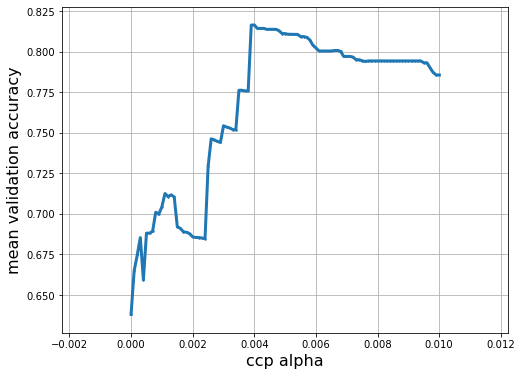

In [18]:
plt.figure(figsize=(8, 6))
plt.xlabel('ccp alpha', fontsize=16)
plt.ylabel('mean validation accuracy', fontsize=16)
plt.scatter(ccp, acc, s=2)
plt.plot(ccp, acc, linewidth=3)
plt.grid(True, which='both')
plt.show()

In [19]:
print('The best complexity parameter from the cross validation:')
dtc_cv.best_params_

The best complexity parameter from the cross validation:


{'ccp_alpha': 0.004}

In [20]:
print('Grid best score (Accuracy): ')
dtc_cv.best_score_

Grid best score (Accuracy): 


0.8164022606549179

In [21]:
print('Node count =')
dtc_cv.best_estimator_.tree_.node_count

Node count =


15

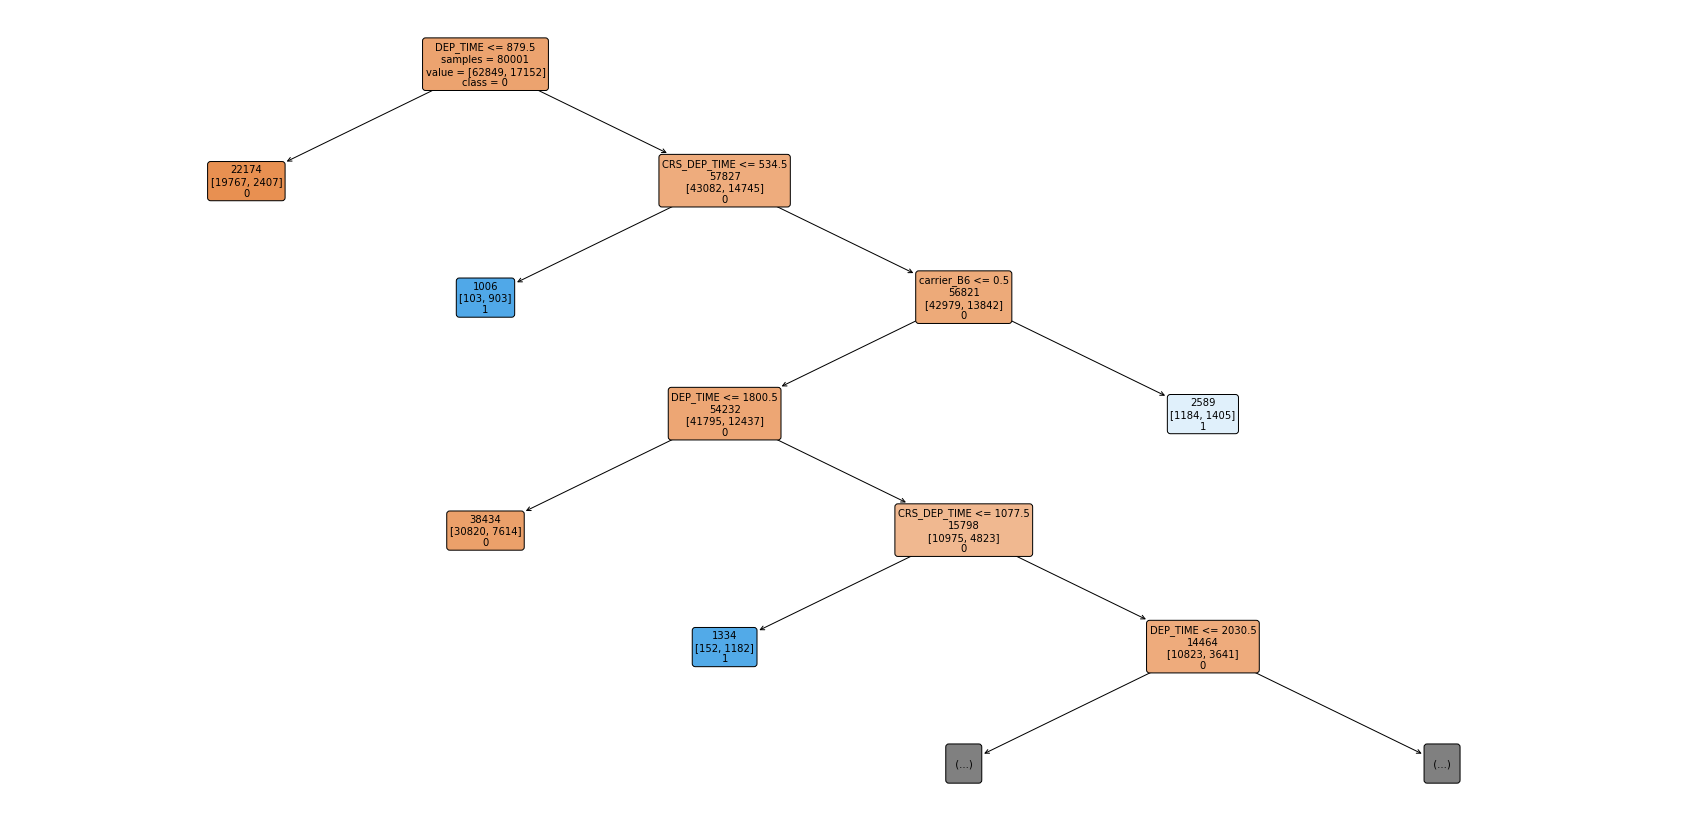

In [22]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(30,15))
plot_tree(dtc_cv.best_estimator_, 
          feature_names=X_train.columns, 
          class_names=['0','1'], 
          filled=True,
          impurity=False,
          rounded=True,
          fontsize=10,
          max_depth = 5,
          label='root')
plt.show()

Confusion Matrix:

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_pred = dtc_cv.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

In [24]:
# Accuracy
acc_dt = (cm.ravel()[0]+cm.ravel()[3])/sum(cm.ravel())
print('Decision Tree Accuracy is: ')
print(acc_dt)

Decision Tree Accuracy is: 
0.7779


In [25]:
TPR_dt = cm.ravel()[3] / (cm.ravel()[3] + cm.ravel()[2])
print('Decision Tree True Positive Rate (TPR) is: ')
print(TPR_dt)

Decision Tree True Positive Rate (TPR) is: 
0.2213130722774206


In [26]:
# False Positive rate
FPR_dt = cm.ravel()[1] / (cm.ravel()[1] + cm.ravel()[0])
print('Decision Tree False Positive Rate (FPR) is: ')
print(FPR_dt)

Decision Tree False Positive Rate (FPR) is: 
0.029932064303490952
